# Make a fit over an entire region of the field

This is a complete example of a fit over an entire region of interest (ROI). The different steps covered are :

1. Extraction of a deep frame and the WCS
2. Definition of the ROI with DS9
3. Fit of a single spectrum in order to get an initial guess on the velocity of the gas
4. Fit of the entire ROI
5. Visualization of the resulting maps

In [1]:
import orcs.process
import pylab as pl
import orb.utils.io
import numpy as np
from importlib import reload

In [2]:
cube = orcs.process.SpectralCube('/home/thomas/local/M57_SN3.merged.cm1.1.0.hdf5')

INFO:root:Cube is level 3
INFO:root:shape: (2048, 2064, 593)
INFO:root:wavenumber calibration: True
INFO:root:flux calibration: True
INFO:root:wcs calibration: True


## Export the deep frame with its WCS to define the ROI

INFO:root:Data written as deep_frame.fits in 0.29 s 


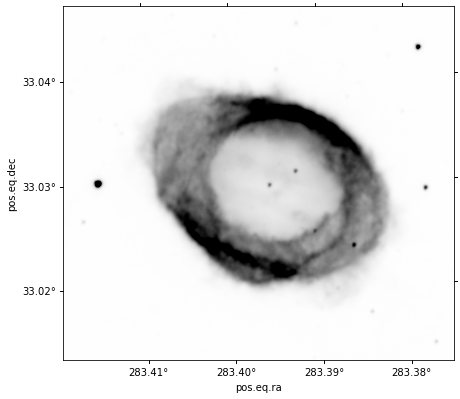

In [3]:
deep_frame = cube.get_deep_frame()
deep_frame.imshow(cmap='gray_r', perc=99.9)
pl.xlim((550,970))
pl.ylim((650,1030))
deep_frame.to_fits('deep_frame.fits')

## Use ds9 to define the ROI

from here you can use ds9 to define the region of interest on the deep frame. You can export the region in celestial or image coordinates. Note that the region can also be passed as a collection of pixel position as it is returned by a function such as numpy.nonzero(). the content of the generated ds9 region file is:

It can be plotted (for checking purpose) with pyregion (http://pyregion.readthedocs.io/en/latest/index.html) like this

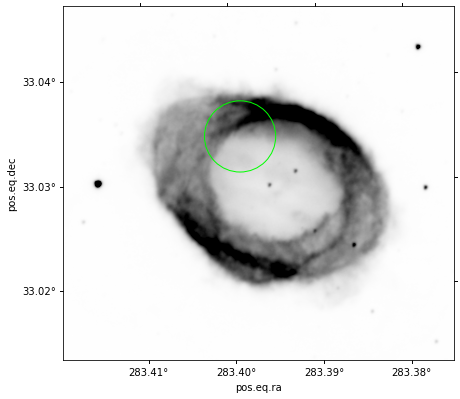

In [4]:
import pyregion

# draw the background image
deep_frame.imshow(cmap='gray_r', perc=99.9)
pl.xlim((550,970))
pl.ylim((650,1030))

# load region file and draw the regions
reg = pyregion.open('region.reg').as_imagecoord(cube.get_wcs_header())

ax = pl.gca()
patch_list, artist_list = reg.get_mpl_patches_texts()
for p in patch_list:
    ax.add_patch(p)
for t in artist_list:
    ax.add_artist(t)
    

## Extract a spectrum of the region to estimate the fit parameters

parameters estimation can be done automatically. Only one velocity component is considered along the line of sight.

velocity estimate (km/s) 60.0
fluxes estimate (erg/cm^2/s) [6.702803507687017e-14, 2.303640071085414e-13, 2.159394315301985e-13, 1.2902492268605936e-14, 1.0764452284205345e-14]


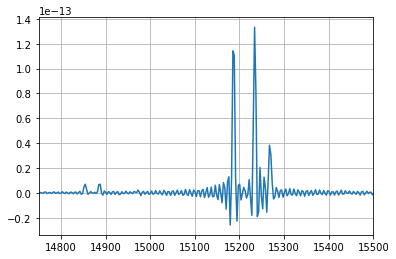

In [5]:
spectrum = cube.get_spectrum(749, 898, 3)

# all the spectrum
spectrum.plot()
pl.xlim((14750,15500))
pl.grid()

vel, fluxes = spectrum.estimate_parameters(('[NII]6548', 'Halpha', '[NII]6583', '[SII]6716', '[SII]6731'), [-300, 300])
print('velocity estimate (km/s)', vel)
print('fluxes estimate (erg/cm^2/s)', fluxes)

/home/thomas/miniconda3/envs/orb3/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


=== Fit results ===
lines: ['[NII]6548', 'H3', '[NII]6584', '[SII]6717', '[SII]6731'], fmodel: sincgauss
iterations: 56, fit time: 4.02e-01 s
Velocity (km/s): [53.74(14) 62.98(15) 53.74(14) 53.74(14) 53.74(14)] 
Flux: [9.372(85)e-14 2.984(12)e-13 2.887(12)e-13 1.753(84)e-14 1.674(84)e-14]
Broadening (km/s): [15.61(54) 17.90(48) 15.61(54) 15.61(54) 15.61(54)]



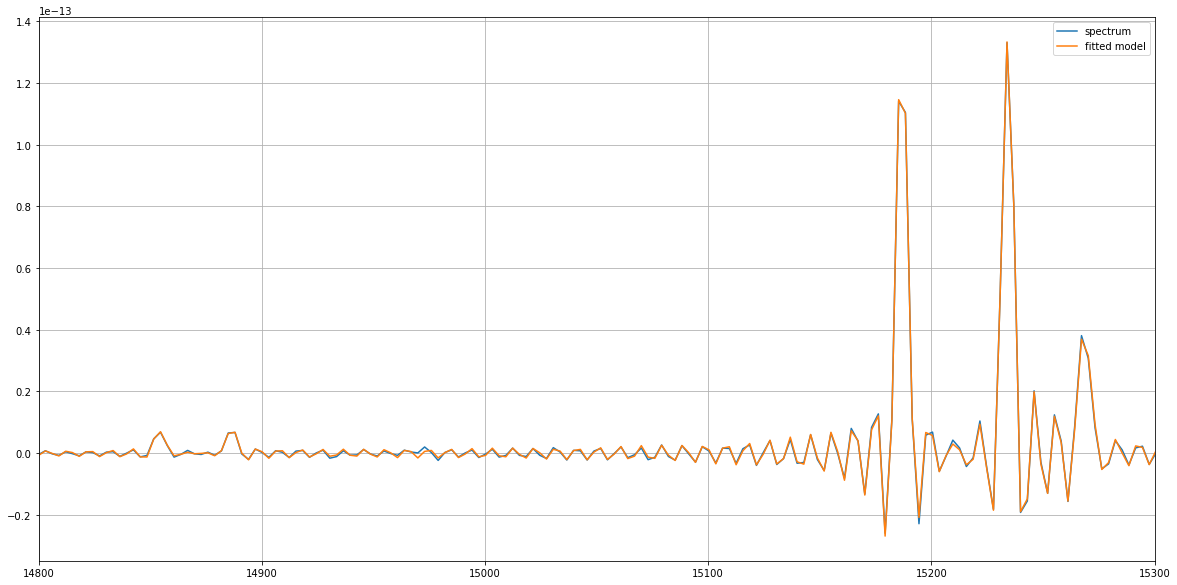

In [7]:
# set up the fit to check if before running the long extraction process over the whole ROI

fit = spectrum.fit(('[NII]6548', 'Halpha', '[NII]6583', '[SII]6716', '[SII]6731'),
                   fmodel='sincgauss', 
                   pos_def=['1','2','1','1','1'], 
                   pos_cov=[vel, vel],
                   sigma_def=['1','2','1','1','1'],
                   sigma_cov=[20, 20],
                   nofilter=True)

print(fit)
new_vel = fit['velocity'][0], fit['velocity'][1]
                                                 
pl.figure(figsize=(20,10))
spectrum.plot(label='spectrum')
fit.get_spectrum().plot(label='fitted model')
pl.xlim((14800,15300))
pl.legend()
pl.grid()

## Fit the ROI

### Estimate parameters in the ROI

We can start by estimating the parameters (especially the velocity) in the region we want to fit. The estimated velocity map can then be used as an input in the fitting process. It is a very fast process which should be always done before running a long fitting process. As an example we will run the estimation on a much larger region of the cube.

In [8]:
estimates = cube.estimate_parameters_in_region('large_reg_m57.reg', ('[NII]6548', 'Halpha', '[NII]6583', '[SII]6716', '[SII]6731'), [-300, 300], 
                                               binning=10)

/home/thomas/miniconda3/envs/orb3/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
INFO:root:Init of the parallel processing server with 32 threads
INFO:root:passed mapped kwargs : []
INFO:root:79 rows to fit
/home/thomas/Astro/Python/ORB/Orb/orb/utils/image.py:1120: RuntimeWarning: Mean of empty slice
  return np.squeeze(np.nanmean(np.nanmean(im_view, axis=3), axis=1))


 [==========] [100%] [completed in 32.7 s]                                    

INFO:root:Closing parallel processing server


INFO:root:Data written as ./M57_SN3/M57_SN3.SpectralCube.estimated_velocity.fits in 0.27 s 
INFO:root:Data written as ./M57_SN3/M57_SN3.SpectralCube.estimated_[NII]6548.fits in 0.27 s 
INFO:root:Data written as ./M57_SN3/M57_SN3.SpectralCube.estimated_Halpha.fits in 0.26 s 
INFO:root:Data written as ./M57_SN3/M57_SN3.SpectralCube.estimated_[NII]6583.fits in 0.26 s 
INFO:root:Data written as ./M57_SN3/M57_SN3.SpectralCube.estimated_[SII]6716.fits in 0.27 s 
INFO:root:Data written as ./M57_SN3/M57_SN3.SpectralCube.estimated_[SII]6731.fits in 0.26 s 


/home/thomas/miniconda3/envs/orb3/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


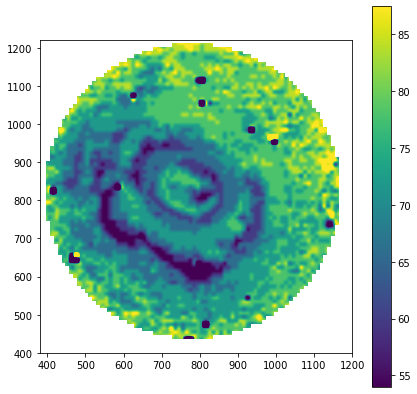

In [9]:
import orb.utils.graph as graph
vel_map = orb.utils.io.read_fits('./M57_SN3/M57_SN3.SpectralCube.estimated_velocity.fits')
graph.imshow(vel_map)
pl.xlim(380, 1200)
pl.ylim(400, 1220)
pl.colorbar()

We are ready to fit all the spectra in the defined ROI.

- The guess on sigma must be small -- as small as the smaller sigma you expect -- but not too small (< 0.1 km/s). 1 km/s is a good guess. In theory we can expect a sigma of 0 km/s for unbroadened lines but the loss of modulation efficiency can broaden the line by a few km/s (see Baril et al. 2016 http://proceedings.spiedigitallibrary.org/proceeding.aspx?doi=10.1117/12.2232075 and Martin et al. 2016 http://cdsads.u-strasbg.fr/abs/2016MNRAS.463.4223M)

- Don't hesitate to fit binned data first, you will gain time and SNR which is a good way to check fitting errors.

-  warning: Jupyter can give an error (neverending fit process) if the fit below is done more than one time. Just restart the kernel as a workaround.

### 3x3 binning

In [10]:
# warning: Jupyter can give an error (neverending fit process) if the fit below is done more than one time. Just restart the kernel as a workaround and run the
# following cells before doing the fit
from orcs.process import SpectralCube
import pylab as pl
import orb.utils.io
import numpy as np

/home/thomas/miniconda3/envs/orb3/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [11]:
cube = SpectralCube('/home/thomas/local/M57_SN3.merged.cm1.1.0.hdf5')

INFO:root:Cube is level 3
INFO:root:shape: (2048, 2064, 593)
INFO:root:wavenumber calibration: True
INFO:root:flux calibration: True
INFO:root:wcs calibration: True


In [5]:
new_vel = 50 # km/s
cube.fit_lines_in_region('region.reg',
        ('[NII]6548', 'Halpha', '[NII]6583', '[SII]6716', '[SII]6731'),
                   fmodel='sincgauss', 
                   pos_def=['1','2','1','1','1'], 
                   pos_cov_map=vel_map,
                   sigma_def=['1','2','1','1','1'],
                   sigma_cov=[20, 20],
                   nofilter=True, binning=3)

INFO:root:Number of spectra to fit: 511
INFO:root:Init of the parallel processing server with 32 threads
INFO:root:passed mapped kwargs : ['pos_cov_0']
INFO:root:26 rows to fit


 [=         ] [11%] [] [remains: unknown]                                     

/home/thomas/Astro/Python/ORB/Orb/orb/utils/image.py:1120: RuntimeWarning: Mean of empty slice
  return np.squeeze(np.nanmean(np.nanmean(im_view, axis=3), axis=1))


 [==========] [100%] [completed in 9.0 s]                                     

INFO:root:Closing parallel processing server


INFO:root:all maps saved as ./M57_SN3/MAPS/M57_SN3.LineMaps.maps.3x3.hdf5
INFO:root:Writing height maps
INFO:root:Data written as ./M57_SN3/MAPS/M57_SN3.LineMaps.map.6548.3x3.height.fits in 0.02 s 
INFO:root:Data written as ./M57_SN3/MAPS/M57_SN3.LineMaps.map.6563.3x3.height.fits in 0.01 s 
INFO:root:Data written as ./M57_SN3/MAPS/M57_SN3.LineMaps.map.6583.3x3.height.fits in 0.01 s 
INFO:root:Data written as ./M57_SN3/MAPS/M57_SN3.LineMaps.map.6716.3x3.height.fits in 0.01 s 
INFO:root:Data written as ./M57_SN3/MAPS/M57_SN3.LineMaps.map.6731.3x3.height.fits in 0.01 s 
INFO:root:Writing height-err maps
INFO:root:Data written as ./M57_SN3/MAPS/M57_SN3.LineMaps.map.6548.3x3.height-err.fits in 0.01 s 
INFO:root:Data written as ./M57_SN3/MAPS/M57_SN3.LineMaps.map.6563.3x3.height-err.fits in 0.01 s 
INFO:root:Data written as ./M57_SN3/MAPS/M57_SN3.LineMaps.map.6583.3x3.height-err.fits in 0.01 s 
INFO:root:Data written as ./M57_SN3/MAPS/M57_SN3.LineMaps.map.6716.3x3.height-err.fits in 0.01 s 


###  Check the results


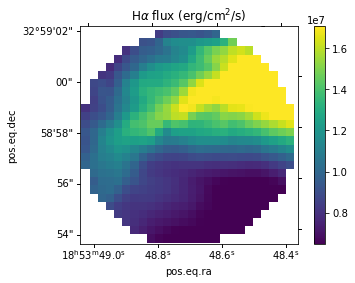

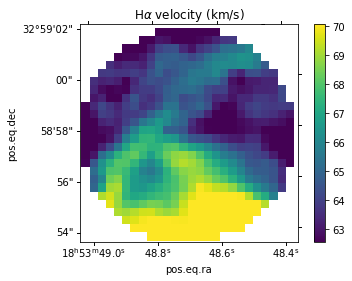

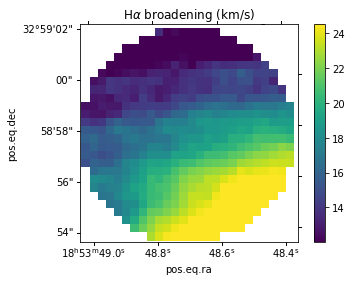

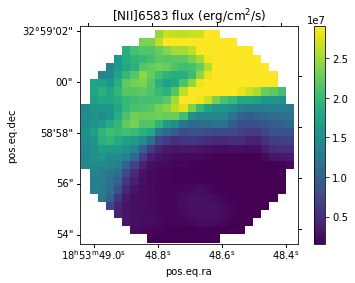

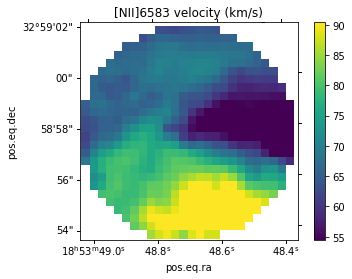

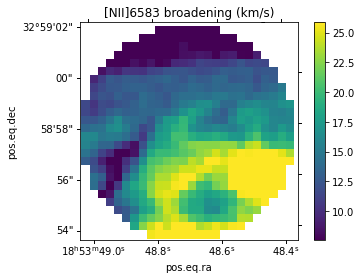

In [8]:
def show_map(path, title):
    fig = pl.figure()
    ax = fig.add_subplot(111, projection=cube.get_wcs())
    ax.coords[0].set_major_formatter('hh:mm:ss.s')
    ax.coords[1].set_major_formatter('dd:mm:ss')
    _map = orb.utils.io.read_fits(path)
    pl.imshow(_map.T, origin='lower', 
              vmin=np.nanpercentile(_map, 10),
              vmax=np.nanpercentile(_map, 90))
    pl.xlim((700/3,780/3))
    pl.ylim((850/3,930/3))
    pl.colorbar()
    pl.title(title)
    
show_map('M57_SN3/MAPS/M57_SN3.LineMaps.map.6563.3x3.flux.fits', r'H$\alpha$ flux (erg/cm$^2$/s)')
show_map('M57_SN3/MAPS/M57_SN3.LineMaps.map.6563.3x3.velocity.fits', r'H$\alpha$ velocity (km/s)')
show_map('M57_SN3/MAPS/M57_SN3.LineMaps.map.6563.3x3.sigma.fits', r'H$\alpha$ broadening (km/s)')
show_map('M57_SN3/MAPS/M57_SN3.LineMaps.map.6583.3x3.flux.fits', r'[NII]6583 flux (erg/cm$^2$/s)')
show_map('M57_SN3/MAPS/M57_SN3.LineMaps.map.6583.3x3.velocity.fits', r'[NII]6583 velocity (km/s)')
show_map('M57_SN3/MAPS/M57_SN3.LineMaps.map.6583.3x3.sigma.fits', r'[NII]6583 broadening (km/s)')


### 1x1 binning

In [1]:
# warning: Jupyter can give an error (neverending fit process) if the fit below is done more than one time. Just restart the kernel as a workaround and run the
# following cells before doing the fit
from orcs.process import SpectralCube
import pylab as pl
import orb.utils.io
import numpy as np

In [2]:
cube = SpectralCube('/home/thomas/local/M57_SN3.merged.cm1.1.0.hdf5', debug=False)

master.11e5|WARNING| both level2 and level3 in attrs
master.11e5|INFO| Cube is level 3
master.11e5|INFO| shape: (2048, 2064, 593)
master.11e5|INFO| wavenumber calibration: True
master.11e5|INFO| flux calibration: True
master.11e5|INFO| wcs calibration: False


In [12]:
# we can use the binned map as an input for the new fit process
vel_map = orb.utils.io.read_fits('./M57_SN3/MAPS/M57_SN3.LineMaps.map.6563.3x3.velocity.fits')
sig_map = orb.utils.io.read_fits('./M57_SN3/MAPS/M57_SN3.LineMaps.map.6563.3x3.sigma.fits')

In [13]:
cube.fit_lines_in_region('region.reg',
        ('[NII]6548', 'Halpha', '[NII]6583', '[SII]6716', '[SII]6731'),
                   fmodel='sincgauss', 
                   pos_def=['1','2','1','1','1'], 
                   pos_cov_map=vel_map,
                   sigma_def=['1','2','1','1','1'],
                   sigma_cov_map=sig_map,
                   nofilter=True, binning=1)

INFO:root:Number of spectra to fit: 4604
INFO:root:Init of the parallel processing server with 32 threads
INFO:root:passed mapped kwargs : ['pos_cov_0', 'sigma_cov_0']
INFO:root:77 rows to fit


 [==========] [100%] [completed in 24.5 s]                                    

INFO:root:Closing parallel processing server


INFO:root:all maps saved as ./M57_SN3/MAPS/M57_SN3.LineMaps.maps.1x1.hdf5
INFO:root:Writing height maps
INFO:root:Data written as ./M57_SN3/MAPS/M57_SN3.LineMaps.map.6548.1x1.height.fits in 0.28 s 
INFO:root:Data written as ./M57_SN3/MAPS/M57_SN3.LineMaps.map.6563.1x1.height.fits in 0.30 s 
INFO:root:Data written as ./M57_SN3/MAPS/M57_SN3.LineMaps.map.6583.1x1.height.fits in 0.28 s 
INFO:root:Data written as ./M57_SN3/MAPS/M57_SN3.LineMaps.map.6716.1x1.height.fits in 0.32 s 
INFO:root:Data written as ./M57_SN3/MAPS/M57_SN3.LineMaps.map.6731.1x1.height.fits in 0.27 s 
INFO:root:Writing height-err maps
INFO:root:Data written as ./M57_SN3/MAPS/M57_SN3.LineMaps.map.6548.1x1.height-err.fits in 0.28 s 
INFO:root:Data written as ./M57_SN3/MAPS/M57_SN3.LineMaps.map.6563.1x1.height-err.fits in 0.28 s 
INFO:root:Data written as ./M57_SN3/MAPS/M57_SN3.LineMaps.map.6583.1x1.height-err.fits in 0.28 s 
INFO:root:Data written as ./M57_SN3/MAPS/M57_SN3.LineMaps.map.6716.1x1.height-err.fits in 0.27 s 


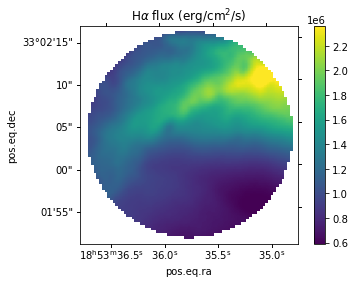

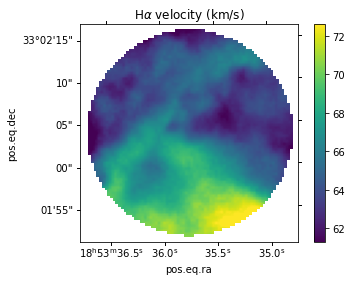

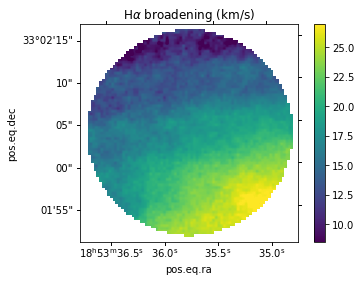

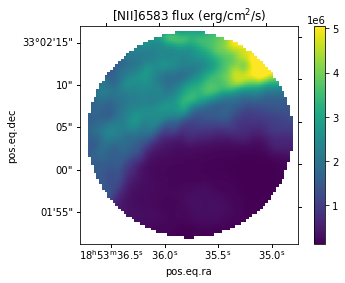

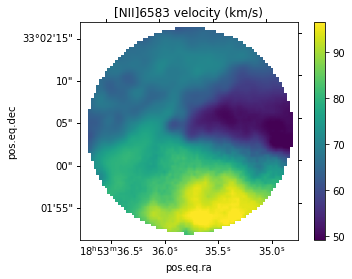

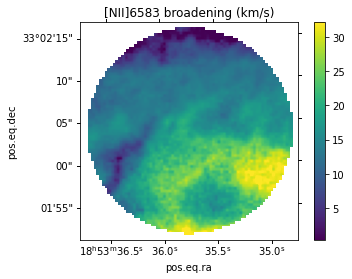

In [14]:
def show_map(path, title):
    fig = pl.figure()
    ax = fig.add_subplot(111, projection=cube.get_wcs())
    ax.coords[0].set_major_formatter('hh:mm:ss.s')
    ax.coords[1].set_major_formatter('dd:mm:ss')
    _map = orb.utils.io.read_fits(path)
    pl.imshow(_map.T, origin='lower', 
              vmin=np.nanpercentile(_map, 1),
              vmax=np.nanpercentile(_map, 99))
    pl.xlim((700,780))
    pl.ylim((850,930))
    pl.colorbar()
    pl.title(title)
    
show_map('M57_SN3/MAPS/M57_SN3.LineMaps.map.6563.1x1.flux.fits', r'H$\alpha$ flux (erg/cm$^2$/s)')
show_map('M57_SN3/MAPS/M57_SN3.LineMaps.map.6563.1x1.velocity.fits', r'H$\alpha$ velocity (km/s)')
show_map('M57_SN3/MAPS/M57_SN3.LineMaps.map.6563.1x1.sigma.fits', r'H$\alpha$ broadening (km/s)')
show_map('M57_SN3/MAPS/M57_SN3.LineMaps.map.6583.1x1.flux.fits', r'[NII]6583 flux (erg/cm$^2$/s)')
show_map('M57_SN3/MAPS/M57_SN3.LineMaps.map.6583.1x1.velocity.fits', r'[NII]6583 velocity (km/s)')
show_map('M57_SN3/MAPS/M57_SN3.LineMaps.map.6583.1x1.sigma.fits', r'[NII]6583 broadening (km/s)')
